In [92]:
import meep as mp
import math
import numpy as np
import matplotlib.pyplot as plt
import argparse

from meep.materials import Au, SiO2

In [93]:
# Add materials not in the meep.materials library
Ac = mp.Medium(index=1.8)
TiO2 = mp.Medium(index=2.35)

In [94]:
l = 0.4     # period of the gratings (lambda)
diam = 4*l  # diameter of the central disk 
ff = 0.67   # filling factor
N = 10      # number of gratings

dpml = 0.5              # thickness of PML
pad = 4.0               # padding between structure and edge of PML
dau = 0.15              # thickness of gold backreflector
ddev = 0.22             # thickness of device layer
dsio2 = 0.44            # thickness of SiO2 spacer
 
sr = 2*(N+1-ff)*l+diam+2*pad+2*dpml        # cell size in x and y direction
sz = 2*(dpml+pad)+dau+ddev+dsio2           # cell size in z direction

cell_size = mp.Vector3(sr,0,sz)      # simulation cell size
res = 100                            # resolution

In [95]:
# Define bullseye geometry with a gold backreflector

geometry = []

geometry.append(mp.Block(size=mp.Vector3(sr,0,ddev),            # Add TiO2 device layer
                     center=mp.Vector3(sr/2,0,0),
                     material=TiO2))

geometry.append(mp.Block(size=mp.Vector3(sr,0,dsio2),           # Add SiO2 spacer layer 
                     center=mp.Vector3(sr/2,0,-(ddev+dsio2)/2),   
                     material=SiO2))

geometry.append(mp.Block(size=mp.Vector3(sr,0,dau),             # Add Au back reflector
                     center=mp.Vector3(sr/2,0,-(ddev+dau)/2-dsio2),
                     material=Au))

for n in range (0,N,+1):                                        # Add N+1 etches (N gratings)
    geometry.append(mp.Block(size=mp.Vector3((1-ff)*l, 0, ddev),center=mp.Vector3(sr/2+diam/2+(1-ff)*l/2+n*l,0,0), material=Ac))          

In [96]:
# Define point-like source in the middle of cavity disk

wvl_min = 0.6           # min wavelength
wvl_max = 1             # max wavelength
wvl_cen = 0.5*(wvl_min+wvl_max)
fmin = 1/wvl_max        # min frequency
fmax = 1/wvl_min        # max frequency
fcen = 0.5*(fmin+fmax)  # center frequency
df = fmax-fmin          # frequency width
src = mp.Source(mp.GaussianSource(fcen, fwidth=df), component=mp.Er, center=mp.Vector3(sr/2,0,0))  #Add dipole-like source

In [97]:
# Define simulation without geometry for normalisation

sim = mp.Simulation(cell_size= cell_size,
                    sources=[src],
                    resolution=res,                    
                    boundary_layers=[mp.PML(dpml)],
                    dimensions = mp.CYLINDRICAL,
                    m=-1)

In [98]:
# Add bottom (z1),up (z2) and sides (r) flux monitors 

nfreq = 100
box_dis = 1 # Distance of the flux plane from the structure 

box_z1 = sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(sr/2,0,-ddev/2-dau-dsio2-box_dis),size=mp.Vector3((N+1-ff)*l+diam/2+2*box_dis)))
box_z2 = sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(sr/2,0,+ddev/2+box_dis),size=mp.Vector3((N+1-ff)*l+diam/2+2*box_dis)))
box_r = sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3((N+1-ff)*l+diam/2+2*box_dis,0,sz/2),size=mp.Vector3(z=dau+ddev+dsio2+2*box_dis)))

time_after_sources = 100

sim.run(until_after_sources=time_after_sources)

flux_freqs = mp.get_flux_freqs(box_z2)
box_z1_data = sim.get_flux_data(box_z1)
box_z2_data = sim.get_flux_data(box_z2)
box_r_data = sim.get_flux_data(box_r)

box_z1_flux0 = mp.get_fluxes(box_z1)

sim.reset_meep()

-----------
Initializing structure...
time for choose_chunkdivision = 0.00020504 s
Working in Cylindrical dimensions.
Computational cell is 18.86 x 0 x 9.81 with resolution 100
time for set_epsilon = 1.75504 s
-----------
Meep: using complex fields.


FloatProgress(value=0.0, description='0% done ', max=115.0)

Meep progress: 0.19/115.0 = 0.2% done in 4.0s, 2422.4s to go
on time step 38 (time=0.19), 0.105358 s/step
Meep progress: 0.405/115.0 = 0.4% done in 8.1s, 2289.1s to go
on time step 81 (time=0.405), 0.0949075 s/step
Meep progress: 0.615/115.0 = 0.5% done in 12.1s, 2255.3s to go
on time step 123 (time=0.615), 0.0960709 s/step
Meep progress: 0.8250000000000001/115.0 = 0.7% done in 16.1s, 2232.3s to go
on time step 165 (time=0.825), 0.0953221 s/step
Meep progress: 1.035/115.0 = 0.9% done in 20.2s, 2221.2s to go
on time step 207 (time=1.035), 0.0962528 s/step
Meep progress: 1.245/115.0 = 1.1% done in 24.2s, 2214.4s to go
on time step 249 (time=1.245), 0.0967287 s/step
Meep progress: 1.455/115.0 = 1.3% done in 28.3s, 2205.2s to go
on time step 291 (time=1.455), 0.0957568 s/step
Meep progress: 1.665/115.0 = 1.4% done in 32.3s, 2201.3s to go
on time step 333 (time=1.665), 0.0971552 s/step
Meep progress: 1.875/115.0 = 1.6% done in 36.4s, 2194.3s to go
on time step 375 (time=1.875), 0.0959704 s/

In [99]:
sim = mp.Simulation(cell_size= cell_size,
                    sources=[src],
                    resolution=res, 
                    geometry=geometry,
                    boundary_layers=[mp.PML(dpml)],
                    dimensions = mp.CYLINDRICAL,
                    m=-1)

nfreq = 100
box_dis = 1 # Distance of the flux plane from the structure 

box_z1 = sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(sr/2,0,-ddev/2-dau-dsio2-box_dis),size=mp.Vector3((N+1-ff)*l+diam/2+2*box_dis)))
box_z2 = sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3(sr/2,0,+ddev/2+box_dis),size=mp.Vector3((N+1-ff)*l+diam/2+2*box_dis)))
box_r = sim.add_flux(fcen, df, nfreq, mp.FluxRegion(center=mp.Vector3((N+1-ff)*l+diam/2+2*box_dis,0,sz/2),size=mp.Vector3(z=dau+ddev+dsio2+2*box_dis)))


sim.load_minus_flux_data(box_z1, box_z1_data)
sim.load_minus_flux_data(box_z2, box_z2_data)
sim.load_minus_flux_data(box_r, box_r_data)

time_after_sources = 100

sim.run(until_after_sources=time_after_sources)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000234127 s
Working in Cylindrical dimensions.
Computational cell is 18.86 x 0 x 9.81 with resolution 100
     block, center = (9.432,0,0)
          size (18.864,0,0.22)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.5225,5.5225,5.5225)
     block, center = (9.432,0,-0.33)
          size (18.864,0,0.44)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (9.432,0,-0.625)
          size (18.864,0,0.15)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (10.298,0,0)
          size (0.132,0,0.22)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.24,3.24,3.24)
     block, center = (10.698,0,0)
          size (0.132,0,0.22)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilo

FloatProgress(value=0.0, description='0% done ', max=115.0)

Meep progress: 0.03/115.0 = 0.0% done in 4.4s, 16773.0s to go
on time step 6 (time=0.03), 0.72861 s/step
Meep progress: 0.075/115.0 = 0.1% done in 8.4s, 12900.7s to go
on time step 15 (time=0.075), 0.449102 s/step
Meep progress: 0.12/115.0 = 0.1% done in 12.5s, 11984.6s to go
on time step 24 (time=0.12), 0.455466 s/step
Meep progress: 0.165/115.0 = 0.1% done in 17.0s, 11821.3s to go
on time step 33 (time=0.165), 0.496248 s/step
Meep progress: 0.21/115.0 = 0.2% done in 21.3s, 11627.4s to go
on time step 42 (time=0.21), 0.476128 s/step
Meep progress: 0.255/115.0 = 0.2% done in 25.7s, 11567.3s to go
on time step 51 (time=0.255), 0.492713 s/step
Meep progress: 0.3/115.0 = 0.3% done in 29.9s, 11431.3s to go
on time step 60 (time=0.3), 0.465796 s/step
Meep progress: 0.34/115.0 = 0.3% done in 34.2s, 11533.2s to go
on time step 68 (time=0.34), 0.537522 s/step
Meep progress: 0.385/115.0 = 0.3% done in 38.2s, 11374.8s to go
on time step 77 (time=0.385), 0.445418 s/step
Meep progress: 0.435/115.0

Text(0, 0.5, 'Arbitrary intensity')

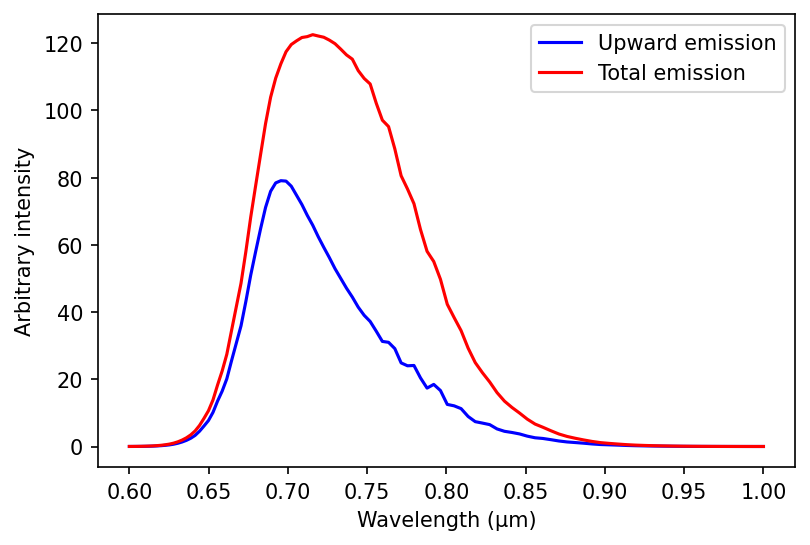

In [102]:
flux_freqs = np.array(mp.get_flux_freqs(box_z2))
flux_up = np.array(mp.get_fluxes(box_z2))
flux_bot = np.array(mp.get_fluxes(box_z1))
flux_side = np.array(mp.get_fluxes(box_r))
flux_total= -flux_bot+flux_up-flux_side

flux_wvl=1/flux_freqs
plt.figure(dpi=150)
plt.plot(flux_wvl, flux_up, 'b-',label='Upward emission')
plt.plot(flux_wvl, flux_total, 'r-', label='Total emission')
plt.legend(loc='upper right')
plt.xlabel('Wavelength (µm)')
plt.ylabel('Arbitrary intensity')
